In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [20]:
image_size = 256
batch_size = 32
channels=3
epochs=50

In [4]:
 class_names = dataset.class_names

In [5]:
len(dataset)

68

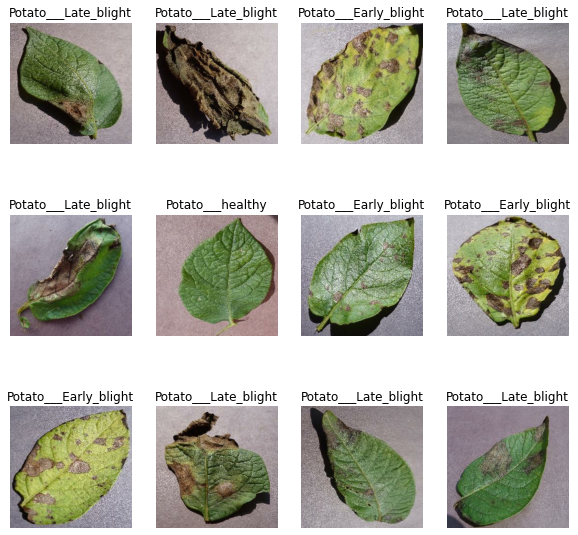

In [6]:
plt.figure(figsize=(10,10))
for i, j in dataset.take(1):
    for k in range(12):
        ax = plt.subplot(3,4,k+1)
        plt.imshow(i[k].numpy().astype('int64'))
        plt.title(class_names[j[k]])
        plt.axis('off')
    #print(j.numpy())

In [7]:
print(j.numpy().shape)

(32,)


In [8]:
train_ds = dataset.take(int(len(dataset)*0.8))
len(train_ds)

54

In [9]:
def get_ds(ds,train_split=0.8, val_split=0.1,test_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds,test_ds

In [10]:
train_ds, val_ds, test_ds = get_ds(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =  val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
resize_and_rescale

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [27]:
history = model.fit(train_ds,batch_size=batch_size,validation_data=val_ds,verbose=1,epochs=1,)

54/54 [==============================] - 347s 6s/step - loss: 0.1135 - accuracy: 0.9601 - val_loss: 0.3668 - val_accuracy: 0.8542


In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 91s 1s/step - loss: 0.3958 - accuracy: 0.8398


In [29]:
scores

[0.39575469493865967, 0.83984375]

In [31]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")
model.save("../potatoes.h5")

INFO:tensorflow:Assets written to: ../models/1\assets
